In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

df = pd.read_csv('processed_data.csv')
df = df[['reviews', 'sentiment']] 

is_not_empty = df['reviews'].str.strip().astype(bool)
# get number of non empty reviews

df['reviews'] = df['reviews'].str.strip()

df = df[(df['reviews'] != "") & (df['reviews'].notna())]

df['sentiment'] = df['sentiment'].map({'negative':0, 'neutral':1, 'positive': 2 })

df.reset_index(drop=True, inplace=True)

df.head(20)
print(df.shape)
df.count()
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


(34973, 2)
sentiment
2    22818
0     6380
1     5775
Name: count, dtype: int64


## Importing Libraries

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Embedding 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import asarray
from numpy import zeros
from keras.layers import LSTM

# Splitting data

In [18]:
X = df['reviews']
y = df['sentiment']

In [19]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

y_train = to_categorical(y_train)
y_test= to_categorical(y_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(23358,) (23358, 3)
(5840,) (5840, 3)


# Preparing embedding layer

In [20]:
word_tokenize = Tokenizer()
word_tokenize.fit_on_texts(X_train) # creates a dictionary mapping each unique word found in training data - this process is often called "building a vocabulary"
# ^ the frequency of each word is also calculated in this phase, this can be useful for tasks like filtering out infrequent words

X_train = word_tokenize.texts_to_sequences(X_train) # takes text and turns them into a list of numbers - each number represents a specific word in the library
X_test = word_tokenize.texts_to_sequences(X_test)

vocab_size = len(word_tokenize.word_index) + 1
maxlen = max([len(x) for x in X_train])
print(maxlen)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) # adds zeros to make sure that all of sequences have the same length
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)




289


### Creating feature matrix using GloVe word embeddings

In [21]:
embeddings_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file: # iterating over every line in the glove_file
  # process each line to extract the word and its vector representation
  records = line.split()
  word = records[0]
  # the embedding word vector is obtained by converting the rest of the list
  # int a NumPy array with float32. This is needed because the the embedding dimension
  # is sorted as a string in the file and we need it to be a floating point number
  # for any mathematical operation we might perform
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions

glove_file.close()

# Creating embedding matrix 
this will contain 100 dimensional GloVe word embeddings for all words 
in our corpus.
The embedding layer of a neural network is the part of the network that takes input data by 
transforming it into dense vectors of fixed size, often at the very beginning of the model's architecture

In [22]:

# here we initialize the embedding matrix with zeros
# this creates a matrix filled with zeros where the number of rows (vocab_size)
# represents the size of our dataset's vocabulary. and the number of columns 
# represents the dimensionality of teh GloVe vectors we're using
embedding_matrix = zeros((vocab_size, 100))
# here we fill teh embedding matrix with embedding vectors from 'embeddings_dict'
for word, index in word_tokenize.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(22106, 100)

# Recurrent Neural Net (LSTM)

In [23]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(228))

lstm_model.add(Dense(3, activation='softmax'))

In [31]:
lstm_model.compile(optimizer='adam', loss = 'focal_loss', metrics=['acc'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 289, 100)          2210600   
                                                                 
 lstm_1 (LSTM)               (None, 228)               300048    
                                                                 
 dense_1 (Dense)             (None, 3)                 687       
                                                                 
Total params: 2511335 (9.58 MB)
Trainable params: 300735 (1.15 MB)
Non-trainable params: 2210600 (8.43 MB)
_________________________________________________________________


#### Training LSTM model

In [32]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=228, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


ValueError: in user code:

    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 252, in __call__
        self.build(y_pred)
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 194, in build
        self._losses = tf.nest.map_structure(
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 365, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/losses.py", line 2965, in get
        return deserialize(identifier, use_legacy_format=use_legacy_format)
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/losses.py", line 2912, in deserialize
        return legacy_serialization.deserialize_keras_object(
    File "/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/src/saving/legacy/serialization.py", line 537, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: 'focal_loss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [26]:
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)
print('lstm model score: ', lstm_score[0])
print('lstm model accuracy: ', lstm_score[1])

183/183 [==============================] - 26s 140ms/step - loss: 0.5308 - acc: 0.7783
lstm model score:  0.5307520031929016
lstm model accuracy:  0.778253436088562


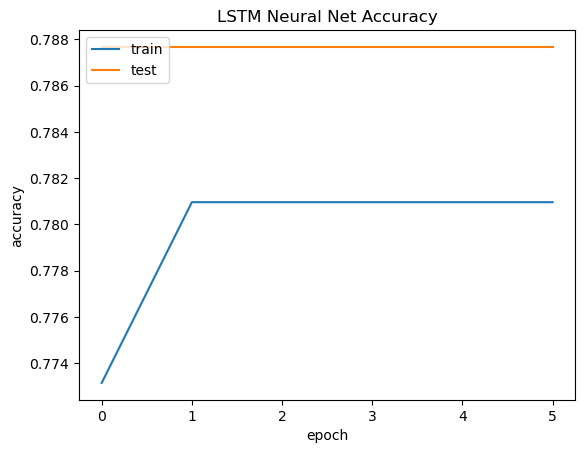

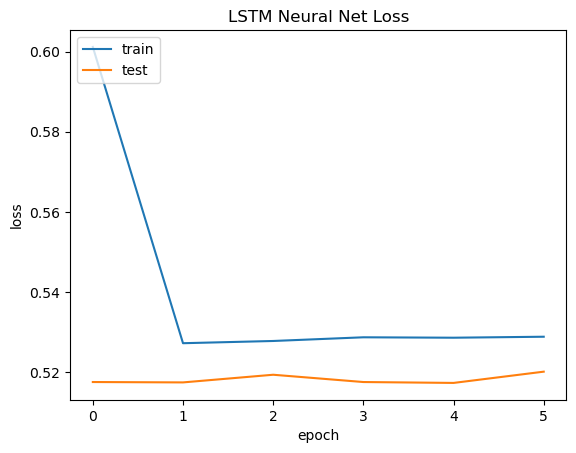

In [27]:

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('LSTM Neural Net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('LSTM Neural Net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()